In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
features = pd.read_csv("temps.csv")

# 看看数据格式
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


数据表中
* year,moth,day,week：分别表示的具体的时间
* temp_2：前天的最高温度值
* temp_1：昨天的最高温度值
* average：在历史中，每年这一天的平均最高温度值
* actual：当天的真实最高温度
* friend：猜测值

In [3]:
print('数据维度:', features.shape)

数据维度: (348, 9)


In [4]:
# 处理时间数据
import datetime

# 分别得到年，月，日
years = features['year']
months = features['month']
days = features['day']

# datetime格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [5]:
dates[:5]

[datetime.datetime(2016, 1, 1, 0, 0),
 datetime.datetime(2016, 1, 2, 0, 0),
 datetime.datetime(2016, 1, 3, 0, 0),
 datetime.datetime(2016, 1, 4, 0, 0),
 datetime.datetime(2016, 1, 5, 0, 0)]

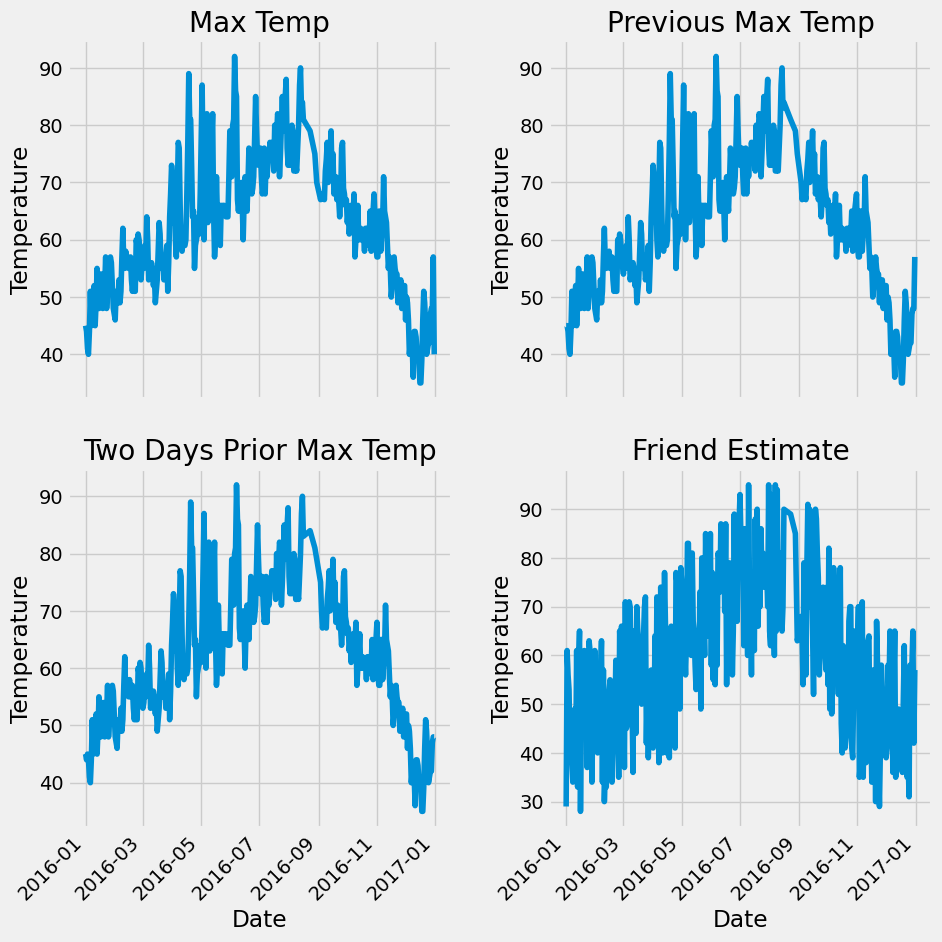

In [6]:
# 准备画图
# 指定默认风格
plt.style.use('fivethirtyeight')

# 设置布局
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
fig.autofmt_xdate(rotation=45)

# 标签值
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# 昨天
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# 前天
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# 朋友预测
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

In [7]:
# 独热编码，pandas自动执行
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,True,False,False,False,False,False,False
1,2016,1,2,44,45,45.7,44,61,False,False,True,False,False,False,False
2,2016,1,3,45,44,45.8,41,56,False,False,False,True,False,False,False
3,2016,1,4,44,41,45.9,40,53,False,True,False,False,False,False,False
4,2016,1,5,41,40,46.0,44,41,False,False,False,False,False,True,False


In [8]:
# 标签
labels = np.array(features["actual"])

# 在特征中去掉标签
features= features.drop("actual", axis=1)

# 名字单独保存一下
feature_list = list(features.columns)

# 转换成合适的格式
features = np.array(features)

In [9]:
features.shape

(348, 14)

In [10]:
# 数据归一化
from sklearn import preprocessing
input_features = preprocessing.StandardScaler().fit_transform(features)

In [11]:
input_features[0]

array([ 0.        , -1.5678393 , -1.65682171, -1.48452388, -1.49443549,
       -1.3470703 , -1.98891668,  2.44131112, -0.40482045, -0.40961596,
       -0.40482045, -0.40482045, -0.41913682, -0.40482045])

### 构建网络模型

In [12]:
x = torch.tensor(input_features, dtype = float)

y = torch.tensor(labels, dtype = float)

# 权重参数初始化
weights = torch.randn((14, 128), dtype=float, requires_grad=True) 
biases = torch.randn(128, dtype=float, requires_grad=True) 
weights2 = torch.randn((128, 1), dtype=float, requires_grad=True) 
biases2 = torch.randn(1, dtype=float, requires_grad=True) 

learning_rate = 0.001 
losses = []

for i in range(1000):
    # 计算隐藏层
    hidden = x.mm(weights) + biases
    # 加入激活函数
    hidden = torch.relu(hidden)
    # 预测结果
    predictions = hidden.mm(weights2) + biases2
    # 计算损失
    loss = torch.mean((predictions - y) ** 2) 
    losses.append(loss.data.numpy())
    
    # 打印损失值
    if i % 100 == 0:
        print('loss:', loss)
    # 反向传播
    loss.backward()

    # 更新参数
    weights.data.add_(- learning_rate * weights.grad.data)  
    biases.data.add_(- learning_rate * biases.grad.data)
    weights2.data.add_(- learning_rate * weights2.grad.data)
    biases2.data.add_(- learning_rate * biases2.grad.data)
    
    # 每次迭代清空梯度
    weights.grad.data.zero_()
    biases.grad.data.zero_()
    weights2.grad.data.zero_()
    biases2.grad.data.zero_()



loss: tensor(10807.5245, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(155.6367, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(147.6215, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(145.0039, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(143.5703, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(142.6194, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.9553, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.4706, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(141.0853, dtype=torch.float64, grad_fn=<MeanBackward0>)
loss: tensor(140.7733, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [13]:
predictions.shape

torch.Size([348, 1])

### 更简单的构建网络模型

In [14]:
input_size = input_features.shape[1]
hidden_size = 128
output_size = 1
batch_size = 16
my_nn = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_size),
    torch.nn.Sigmoid(),
    torch.nn.Linear(hidden_size, output_size),
)
cost = torch.nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(my_nn.parameters(), lr=0.001)

In [15]:
# 训练网络
losses = []
for i in range(1000):
    batch_loss = []
    # mini-batch方法来进行训练
    for start in range(0, len(input_features), batch_size):
        end = start + batch_size if start + batch_size < len(input_features) else len(input_features)
        xx = torch.tensor(input_features[start:end], dtype=torch.float, requires_grad=True)
        yy = torch.tensor(labels[start:end], dtype=torch.float, requires_grad=True)
        prediction = my_nn(xx)
        loss = cost(prediction, yy)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        batch_loss.append(loss.data.numpy())
    
    # 打印损失
    if i % 100==0:
        losses.append(np.mean(batch_loss))
        print(i, np.mean(batch_loss))

0 3968.6804
100 37.436333
200 35.581936
300 35.25996
400 35.089035
500 34.94991
600 34.82579
700 34.703014
800 34.574062
900 34.43921


预测训练结果

In [16]:
x = torch.tensor(input_features, dtype = torch.float)
predict = my_nn(x).data.numpy()

In [17]:
# 转换日期格式
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# 创建一个表格来存日期和其对应的标签数值
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# 同理，再创建一个来存日期和其对应的模型预测值
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predict.reshape(-1)}) 

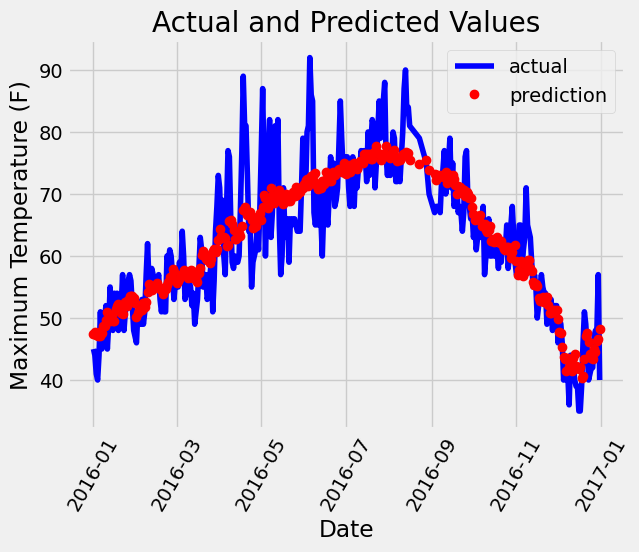

In [18]:
# 真实值
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# 预测值
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = 60); 
plt.legend()

# 图名
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');
